# Introduction to Machine Learning (CSCI-UA.473)

## Analysis of Binary Classifiers and Linear Support Vector Machines

This homework has two parts. In the first part you will do some error analysis of a binary classifier. In the second part you will implement a dual form of a linear support vector machine without the optimizing algorithm.

## Question P1: Metrics for a binary classifier (20 Points Total)

In this problem you will convert your logistic regression model into a binary classifier by learning an `operating point` on the ROC curve of your model. In addition you will also compute and report certain error metrics on your binary classifier. 

### Train a logistic regression model for Breast Cancer Classification using Sklearn (do nothing here)

Here we first train a logistic regression model for the problem of Breast Cancer Classification. 

In [58]:
# Load the packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
from sklearn.datasets import make_blobs, load_breast_cancer
from sklearn.linear_model import LogisticRegression
import pandas as pd

# General helper method to convert sci-kit datasets to Pandas DataFrame.
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    return df

cancer_dataset = load_breast_cancer() # Load the data and convert to a pandas dataframe
df = sklearn_to_df(cancer_dataset)

# Split the data.  DO NOT TOUCH THE TEST DATA FROM HERE ON!!
train_data, val_data = model_selection.train_test_split(df, test_size = 0.2) # 0.2 is 20% validation data.

# Split the features from the class labels.
X_train = train_data.drop('target', axis = 1) # We drop the target from the features.  
X_val  = val_data.drop('target', axis = 1)  # Note that this does not operate inplace.
 
y_train = train_data['target']
y_val  = val_data['target']


# Now fit a logistic regression model.
model = LogisticRegression(solver = 'liblinear', class_weight = 'balanced')
model.fit(X_train, y_train);

# get the default predictions on the validation set 
val_pred = model.predict(X_val)

# Precision score.
precision = metrics.precision_score(y_val, val_pred)
print("Precision = {:0.1f}%".format(100 * precision))

# Recall score.
recall = metrics.recall_score(y_val, val_pred)
print("Recall    = {:0.1f}%".format(100 * recall))

# get the values of the probabilities generated by the logistic regression
val_prob = model.predict_proba(X_val)

Precision = 96.2%
Recall    = 100.0%


### P1.a: Plot the ROC curve (10 Points)


True Positive Rate (TPR) (also called Recall) is defined as: 
$$
\text{TPR} = \frac{TP}{TP + FN}
$$

where $TP$ = number of true positive examples and $FN$ = number of false negative examples. An example is $TP$ if the models says `yes` and the true answer is `yes`. An example is $FN$ if the model says `no` but the true answer is `yes`. 

False Positive Rate (FPR) is defined as follows:
$$
\text{FPR} = \frac{FP}{FP + TN}
$$

where $FP$ = number of false positive examples and $FP$ = number of false negative examples. An example is $FP$ if the models says `yes` but the true answer is `no`. An example is $TN$ if the model says `no` and the true answer is `no`. 

An ROC curve plots TPR (y-axis) vs. FPR (x-axis) at all classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. 

See this for more details (https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

Plot the ROC curve on the validation set for the above problem. **Note that you are not allowed to use any library function to compute the ROC. You have to do it from scratch.**

In [59]:
def toList(x):
    
    #converts panda and numpy objects into a list
    if type(x) == list:
        return x
    
    return x.tolist()

In [60]:
def classify(predictions, validations):

    #convert the data to list, easier to parse
    predictions = toList(predictions)
    validations = toList(validations)
    
    #make sure lengths are the same
    if len(predictions) != len(validations):
        raise IllegalArgumentException("Length of predictions and validation data must match.")
        
    tpcount = 0
    fncount = 0
    fpcount = 0
    tncount = 0
    
    #classify each example as tp, tn, fp, or fn
    for i in range(len(predictions)):
        if(validations[i] == 1):
            if(predictions[i] == 1):
                tpcount += 1
            else:
                fncount += 1
        else:
            if(predictions[i] == 1):
                fpcount += 1
            else: 
                tncount += 1
    #return as list
    return [tpcount/len(predictions), fncount/len(predictions), fpcount/len(predictions), tncount/len(predictions)]

In [61]:
def rates(predictions, validations):
    
    c = classify(predictions, validations)
    tpr = c[0]/(c[0]+c[1])
    fpr = c[2]/(c[2]+c[3])
    
    return [tpr, fpr]

In [62]:
#We want to check thresholds 0.01, 0.02, ... 0.98, 0.99
thresholds = np.arange(.01, 1, .01).tolist()

#classificantion probabilities
classProb = model.predict_proba(X_val)[:,1]

classOfAllThresh = dict()

In [63]:
#classify based on threshold
for i in range(len(thresholds)): 
    
    threshClassifications = []
    
    for j in range(len(classProb)):
        
        if(classProb[j] >= thresholds[i]): 
            threshClassifications.append(1)
        else: 
            threshClassifications.append(0)
            
    #add threshold to dict       
    classOfAllThresh.update({thresholds[i]: threshClassifications})
    
    del threshClassifications

classDF = pd.DataFrame(classOfAllThresh)

In [64]:
fprOfAllThresholds = []
tprOfAllThresholds = []

for i in classDF.columns:
    
    r = rates((classDF[i]), y_val)
    tprOfAllThresholds.append(r[0])
    fprOfAllThresholds.append(r[1])

In [65]:
dummyData = np.arange(0, 1.1, .1)

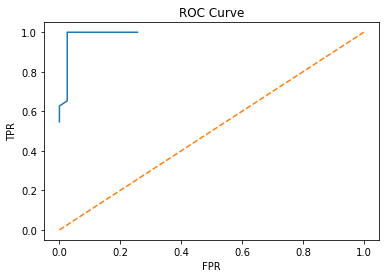

In [66]:
plt.plot(fprOfAllThresholds, tprOfAllThresholds)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(dummyData, dummyData, linestyle = "dashed")
plt.title("ROC Curve")
plt.show()

### P1.b: Compute the AUC of ROC (10 Points)

AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1). AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. 

Consider the following example in which the predictions are sorted from left to right in ascending order of logistic regression probabilities for one class (say class 1): 
$$
\begin{array}
&  & 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 \\ 
Prob: & 0.0 \rightarrow &  1.0
\end{array}
$$

Positive and negative examples ranked in ascending order of logistic regression score. AUC represents the probability that a random positive example (1) is positioned to the right of a random negative example (0). AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

AUC is desirable for the following two reasons:

* AUC is scale-invariant. It measures how well predictions are ranked, rather than their absolute values.
* AUC is classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.

Compute the AUC of your logistic regression model. **Note that you are not allowed to use any library function to compute the AUC. You have to do it from scratch.**

In [67]:
def trapIntegrate(yValues, stepSize):
    sum = 0 
    for i in range(len(yValues)-1):
        sum += (yValues[i] + yValues[i+1])*(stepSize/2)
    return sum

In [68]:
auc = trapIntegrate(tprOfAllThresholds, 0.01)
auc

0.9494666666666672

## Question P2: Linear Support Vector Machines (50 Points Total)

In this problem you will implement a linear SVM by solving the dual problem and apply it to the Iris dataset (https://archive.ics.uci.edu/ml/datasets/iris). The original dataset has $4$ features with $3$ classes, but in this homework we'll only use the first two features and ignore the first class in order to make this a binary classification problem.

You will need the following packages below to do the homework.  Please DO NOT import any other packages.

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.optimize import minimize
import matplotlib.pyplot as plt

### Loading and splitting the data (nothing to do)

The following cell loads the data and pre-processes it to be used for training later.  **Do not modify anything in this cell**.

In [80]:
# Load in the data.
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Ignore the first class and use only the first 2 features.
X = X[y != 0, :2]
y = y[y != 0]

# Make sure that the class labels are either +1 or -1.
y[y==2] = -1

n_sample = len(X)

# Randomly order the data.
np.random.seed(0)
order = np.random.permutation(n_sample)
X = X[order]
y = y[order].astype(float)

# Split the data into 10% testing and 90% training.
X_train = X[:int(.9 * n_sample)]
y_train = y[:int(.9 * n_sample)]
X_test = X[int(.9 * n_sample):]
y_test = y[int(.9 * n_sample):]

### P2.a:  Implement the function to compute the inner product matrix (5 Points)

For training data $\mathcal{D} = \{x_1, x_2, \ldots, x_n\}$, where $x_i \in \Re^p \, \forall i$, the inner product matrix $M \in \Re^{n \times n}$ is defined by 

$$
M = \begin{bmatrix}
m_{1,1} & m_{1,2} & \cdots & m_{1,n}\\
m_{2,1} & m_{2,2} & \cdots & m_{2,n}\\
\vdots & \vdots & \vdots & \vdots \\
m_{n,1} & m_{n,2} & \cdots & m_{n,n}\\
\end{bmatrix}
$$

where $m_{i,j} = \langle x_i, x_j\rangle \in \Re$ is the inner product of the vectors $x_i$ and $x_j$. 

Implement the function below that takes in the data matrix $X$ of training data and returns the corresponding inner product matrix $M$. You may use the numpy function `np.dot()`.  Note that the data matrix $X \in \Re^{n \times p}$ is a matrix whose $i^{th}$ row is the input sample $x_i$. $p$ is the dimension of each input $x_i$. 

Also answer the following two questions below.

1. What is the fewest number of inner products do you need to compute?  Explain why.

2. What are the diagonal entries of the matrix $M$?

In [81]:
def inner_product_matrix(X):
    """
    Compute the inner product matrix of the training data X where each row is a different data point x_i.
    
    Input:
        X: np.ndarray(n, p), n data points in dimension of p
    
    Return:
        M: np.ndarray(n, n), each entry is the inner product of the corresponding pair of vectors m_{ij}
    """
    ##TODO-start##
    M = np.dot(X, X.T)    
    return M
    ##TODO-end##

**Answers to the two theoretical questions goes here.**

In [82]:
#1. Note that inner products are commutative, meaning that <xi, xj> = <xj, xi>. 
#Thus we do not have to recompute the inverses. Thus, the fewest inner products we have to compute is n!. 
#2. The diagonal entries are the dot product of a vector with itself – equal to the square of its magnitude. 
#Note that these values are always positive. 

### P2.b: Implement the objective function of the dual form of linear SVM (10 Points)

Recall that for linear SVM the dual problem is given by 

\begin{align*}
\max_{\alpha} W(\alpha) &= \sum_{i=1}^n \alpha_i - \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n} y_i y_j \alpha_i \alpha_j \langle x_i, x_j\rangle \\
\text{s.t.} & \quad 0 \le \alpha_i \le C, \quad i = 1,\ldots,n \\
& \sum_{i=1}^n \alpha_i y_i = 0
\end{align*}

where $\alpha \in \mathbb{R}^n$ is a vector.  

Implement the objective function $W(\alpha)$ which also takes the training data features and labels as parameters.  Do not worry about the constraints for the moment since you will deal with these next.

* You may also find the function `np.diag()` useful to help vectorize your code and make it run faster.
* Instead of writing your own optimization algorithm, use the scipy function `scipy.optimize.minimize()` to automatically optimize $\alpha$. (Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) 
* Note that the `minimize()` function minimizes the objective function, so you'll need to reformulate the dual problem as a minimization problem with the following trick.
$$
\alpha^* = \text{argmax}_{\alpha}[W(\alpha)]=\text{argmin}_{\alpha}[-W(\alpha)].
$$

Let H be a matrix such that H_i,j=y(i)y(j)<x(i)x(j)>, and set sums to vector form –  which turns this into a minimization problem and reverses the inequality.

\begin{align*}
\min_{\alpha} W(\alpha) &= \frac{1}{2}\alpha^T\textbf{H}\alpha - 1^T\alpha \\
\text{s.t.} & -\alpha_i \ge 0, \quad i = 1,\ldots,n \\
& \sum_{i=1}^n \alpha_i y_i = 0
\end{align*}

In [83]:
def objective_function(a, X, y):
    """
    The objective function of the dual problem W.
    
    Input:
        a: np.ndarray(n,), the parameter alpha we want to optimize
        X: np.ndarray(n, p), the matrix of training data features
        y: np.ndarray (n,), the vector of training data labels, must be either +1 or -1.
    
    Return:
        W: float, value of the objective function. 
    """
    ##TODO-start## 
#     fun = 0.5*a.T*inner_product_matrix(X)*a - (np.ones((a.size,), dtype=int)).T*a
#     W = minimize(fun, a)
    
    maximize =  np.sum(a) - .5 * np.sum((y[None, :] * y[:, None]) * (a[None, :] * a[:, None]) * inner_product_matrix(X))
    minimize = lambda a : -maximize

    ##TODO-end##
    return minimize

### P2.c: Implementing the `fit()` function (30 Points)

There are several pieces you will need to implement.  Read the documentation carefully to set everything up correctly.

1. Get the box constraints $0 \le \alpha_i \le C$ for $i=1,\ldots,n$.  You will pass this into `minimize()` as the `bounds` argument.

2. Get the linear constraint $\sum_{i=1}^n \alpha_i y_i = 0$.  You will pass this into `minimize()` as the `constraints` argument.

3. Call `minimize()` using the correct objective function $-W(\alpha)$ as well as the constraints and bounds from the previous 2 parts.  Use $\alpha_0 = 0 \in \mathbb{R}^n$ as the initial point and use the SLSQP method.

4. Compute the primal variable $w \in \mathbb{R}^p$ using the formula

$$
    w = \sum_{i=1}^n \alpha_i y_i x_i
$$

4. Compute the bias term using the formula

$$
     b = \frac{1}{n} \sum_{i=1}^{n}\left(y_i - \sum_{j=1}^n \alpha_j y_j \langle x_j, x_i \rangle \right) = \frac{1}{n} \sum_{i=1}^n \left(y_i - w^T x_i \right)
$$

once you have computed the minimizer $\alpha$.


Hints:
* Read the explanations of `fun`, `x0`, `bounds`, `constraints`, corresponding to objective function, initialization, bounds, and constraints.
* Equality constraints mean that the constraint function result is zero.
* If `res = minimize(...)`, then `res.x` is the minimizer.

In [84]:
def fit(X, y, C):
    """
    Computes the parameters alpha and bias that determine the maximum-margin decision boundary for SVM.
    
    Input:
        X: np.ndarray(n,p), matrix of training data features
        y: np.ndarray(n, ), vector of training data labels
        C: float, slack parameter that is non-negative
        
    Return:
        w: np.ndarray(p,), vector of primal variable values (vector orthogonal to decision boundary)
        bias: float, the bias term in SVM
        alpha: np.ndarray(n, ), vector of dual variable values
    """
    
    a = np.random.rand(len(X))
    
    fun = objective_function(a, X, y)
    
    x0 = np.random.rand(len(y))
    
    #part 1
    bounds = [(0, C)] * 90
    
    #part 2
    constraints = ({"type" : "eq", "fun" : lambda a: np.dot(a, y)}) 
    
    #part 3, run through the minimize function
    res = minimize(fun, x0, bounds = bounds, constraints = constraints, method = "SLSQP")
    
    alpha = res.x
    
    # Compute the primal variables w.
    w = np.sum((alpha[:, None] * y[:, None] * X), axis=0) #just sum the columns 
    
    # Compute the bias.
    n = len(y)
    bias = 1/n * np.sum((y[:, None] - w.T * X))
    
    ## TO-DO ENDS HERE ##
    return (w, alpha, bias)

### Plotting the results (nothing to do here)
Please DO NOT change anything here. This may take a few minutes to finish the optimization.

* If your implementation is perfect there won't be any errors thrown and it will show a figure similar to the first one in https://scikit-learn.org/stable/auto_examples/exercises/plot_iris_exercise.html#sphx-glr-auto-examples-exercises-plot-iris-exercise-py (ignore if the colors are swapped).

In [85]:
w, alpha, bias = fit(X_train, y_train, C = 10)

<ipython-input-86-851c6318e395>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)


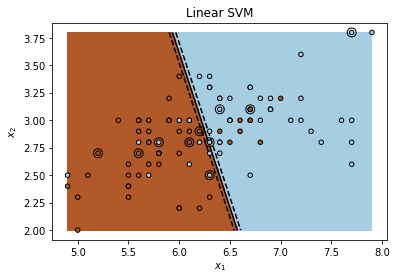

In [86]:
plt.figure(1)
plt.clf()
plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired,
            edgecolor='k', s=20)

# Circle out the test data
plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none',
            zorder=10, edgecolor='k')

plt.axis('tight')
x_min = X[:, 0].min()
x_max = X[:, 0].max()
y_min = X[:, 1].min()
y_max = X[:, 1].max()

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
XXYY = np.c_[XX.ravel(), YY.ravel()]
ZZ = []
for i in range(XXYY.shape[0]):
    ZZ.append(XXYY[i]@w+bias)
    
Z = np.array(ZZ)

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
            linestyles=['--', '-', '--'], levels=[-.5, 0, .5])
plt.title('Linear SVM')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

### P2.d: Implement the `predict()` function (5 Points)

Implement the `predict()` function which computes the discriminant function on the test data and returns a vector whose entries are either $+1$ or $-1$.  Use the primal variable $w$ along with the bias $b$.  You **do not** need to modify the `accuracy()` function or other code in this cell.  If your method is correct you should achieve around 70% accuracy on both training and testing sets.

In [87]:
def predict(x_test, w, bias):
    """
    Compute the predictions y_pred on the test set using only the support vectors.
    
    Input:
        x_test: np.ndarray(n,p), matrix of the test data
        alpha: np.ndarray(n,), vector of the dual variables
        bias: float, the bias term
    
    Output:
        y_pred: np.ndarray(n,), vector of the predicted labels, either +1 or -1
    """
    ##TODO-start##
    y_pred = []
    
    for i in x_test:
        y = np.dot(w, i) + bias
        if(y < 0):
            y_pred.append(-1)
        elif(y > 0):
            y_pred.append(1)
        else:
            y_pred.append(0)
            
    return y_pred
    ##TODO-end##


    
def accuracy(y_pred, y_true):
    """
    Computes the accuracy on the test set given the class predictions.
    
    Input:
        y_pred: np.ndarray(n,), vector of predicted class labels
        y_true: np.ndarray(n,), vector of true class labels
    
    Output:
        float, accuracy of predictions
    """
    return np.mean(y_pred*y_true > 0)

y_pred = predict(X_test, w, bias)
y_pred_train = predict(X_train, w, bias)
print("Training accuracy = {:0.2f}%".format(100*accuracy(y_pred_train, y_train)))
print("Testing accuracy = {:0.2f}%".format(100*accuracy(y_pred, y_test)))

Training accuracy = 74.44%
Testing accuracy = 70.00%
